## Beta regression method applied to modelling the % palm swamp composition 
#### Tutorial - https://towardsdatascience.com/a-guide-to-the-regression-of-rates-and-proportions-bcfe1c35344f

- this code has been adapted from the previous OLS implementation in Paper2_regression_analysis-PS2.ipynb

In [100]:
import os
import rpy2.robjects as robjects
# to specify an R function use: robjects.r["function name"], e.g. r_lm = robjects.r['lm']

# to import R package libraries
from rpy2.robjects.packages import importr
r_cluster = importr('cluster')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle as pkl
import scipy as sp
from scipy import stats
from random import choices
from string import ascii_lowercase
import itertools
import yellowbrick
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.contrib.statsmodels import StatsModelsWrapper
import statsmodels.api as sm
import statsmodels.formula.api as smf
from functools import partial
import patsy
import csv


from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error,r2_score, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn import compose, linear_model, metrics, pipeline, preprocessing
from yellowbrick.features import Rank2D, Rank1D

import matplotlib.patches as mpatches
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


In [101]:
WRKDIR = '/home/s0677837/Datastore/PHD/'
PLOTS = WRKDIR + 'Analysis/Plots/'
Chirps = WRKDIR + 'CHIRPS/Dekad/'
Chirps_daily = WRKDIR + 'CHIRPS/'
AET = WRKDIR + 'ET/FEWSNET_dekad/'
ALOS = WRKDIR + 'ALOS2/Congo/BEAM-DIM/stacked_100m/'
PKL = WRKDIR + 'PKL/'
HAND = WRKDIR + 'MERIT/'
FINAL = WRKDIR + 'Reports/hydro_images/'

#### Function declarations

In [102]:
import pandas as pd
import statsmodels.formula.api as smf

def get_vif(exogs, data):
    '''Return VIF (variance inflation factor) DataFrame

    Args:
    exogs (list): list of exogenous/independent variables
    data (DataFrame): the df storing all variables

    Returns:
    VIF and Tolerance DataFrame for each exogenous variable

    Notes:
    Assume we have a list of exogenous variable [X1, X2, X3, X4].
    To calculate the VIF and Tolerance for each variable, we regress
    each of them against other exogenous variables. For instance, the
    regression model for X3 is defined as:
                        X3 ~ X1 + X2 + X4
    And then we extract the R-squared from the model to calculate:
                    VIF = 1 / (1 - R-squared)
                    Tolerance = 1 - R-squared
    The cutoff to detect multicollinearity:
                    VIF > 10 or Tolerance < 0.1
    '''

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # create formula for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        formula = f"{exog} ~ {' + '.join(not_exog)}"

        # extract r-squared from the fit
        r_squared = smf.ols(formula, data=data).fit().rsquared

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif


In [103]:
# Variance inflation factor calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_VIF(df):
    X = add_constant(df)
    X =df
    return pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

In [104]:
## Logistic regression functions (natural logarithm)
def convert_log(y,column_name):
    # converting y to log for logistic regression
    p = np.asarray(y)
    y = np.log(p / (1 - p))
    
    # flattening the resulting array and converting to numpy 
    y = np.array(list(itertools.chain(*y)))
    
    # converting to pandas dataframe - required for input to regression algorithm
    y = pd.DataFrame(y, columns=[column_name])
    return(y)

def convert_original(y,column_name):
    # following the logistic regression converting back to the original % values  
    p = np.asarray(y)
    y = 1 / (1 + np.exp(-p))
    
    # flattening the resulting array and converting to %
    #y = np.array(list(itertools.chain(*y)))*100
    y = np.array(list(itertools.chain(*y)))
    y = pd.DataFrame(y, columns=[column_name])
    return (y)

In [105]:
## This is a python implementation of the beta regression method, but not currently used - using R version instead

from scipy.special import loggamma
from scipy.special import expit, logit
from scipy.optimize import minimize

def logLikelihood(params, y, X):
    b = np.array(params[0:-1])      # the beta parameters of the regression model
    phi = params[-1]                # the phi parameter
    print (b)
    print (phi)
    
    mu = expit(np.dot(X,b))
   
    eps = 1e-6                      # used for safety of the gamma and log functions avoiding inf
    res = - np.sum(loggamma(phi+eps) # the log likelihood
                   - loggamma(mu*phi+eps) 
                   - loggamma((1-mu)*phi+eps) 
                   + (mu*phi-1)*np.log(y+eps) 
                   + ((1-mu)*phi-1)*np.log(1-y+eps))

    return res

#### Reading in the data

In [106]:
# loading the swamp_data_cats dataframe - output from QS_rclim_grid_5km.ipynb
swamp_data_cats = pkl.load(open(PKL + 'swamp_data_cats_5km.pkl', 'rb'))

# opening the 5x10km grid lats and lons points
lats_new = pkl.load(open(PKL + 'lats_new_5km.pkl', 'rb'))
lons_new = pkl.load(open(PKL + 'lons_new_5km.pkl', 'rb'))

In [107]:
swamp_data_cats.columns

Index(['lat_cat', 'lon_cat', 'type', '% combined swamps', '% composition',
       '% swamp composition', '% water composition', 'DJF', 'DJF_std', 'MAM',
       'MAM_std', 'JJA', 'JJA_std', 'SON', 'SON_std', 'Annual rainfall',
       'Annual_rainfall_std', 'TPI', 'TPI_std', 'elevation', 'elevation_std',
       'slope', 'slope_std', 'HAND', 'HAND_std', 'aspect', 'aspect_std',
       'roughness', 'roughness_std', 'ruggedness', 'ruggedness_std',
       'DJF Tmax', 'DJF Tmax_std', 'MAM Tmax', 'MAM Tmax_std', 'JJA Tmax',
       'JJA Tmax_std', 'SON Tmax', 'SON Tmax_std', 'lat', 'lon', 'lat_mean',
       'lon_mean', 'basin', 'type_count', 'country', '% swamp composition cat',
       'Annual rainfall cat', 'TPI cat', 'slope cat', 'HAND cat',
       'elevation cat', 'ruggedness cat', 'roughness cat', 'aspect cat'],
      dtype='object')

In [108]:
ps = swamp_data_cats[swamp_data_cats['basin']==1]
ps = ps[ps['type']==4]
ps

,lat_cat,lon_cat,type,% combined swamps,% composition,% swamp composition,% water composition,DJF,DJF_std,MAM,...,country,% swamp composition cat,Annual rainfall cat,TPI cat,slope cat,HAND cat,elevation cat,ruggedness cat,roughness cat,aspect cat
5468,93.0,28.0,4.0,3.5032,0.4072,11.6237,38.9382,376.808460,1.236986,462.576723,...,1,<19.1736%,1650.1199 to 1745.8593mm,<-0.0858,0.3262 to 1.0299$^\circ$,>12.9762m,<314.0083m,0.5745 to 1.6501$^\circ$,1.676 to 4.9817$^\circ$,<160.082$^\circ$
5594,94.0,28.0,4.0,8.7483,1.4981,17.1245,21.6743,374.351271,1.891767,460.643710,...,1,<19.1736%,1650.1199 to 1745.8593mm,<-0.0858,0.3262 to 1.0299$^\circ$,5.6775 to 10.3759m,<314.0083m,0.5745 to 1.6501$^\circ$,1.676 to 4.9817$^\circ$,<160.082$^\circ$
5720,95.0,28.0,4.0,22.6715,7.2619,32.0310,18.1669,371.784115,2.250394,461.725625,...,1,19.1736 to 59.0538%,1650.1199 to 1745.8593mm,<-0.0858,0.3262 to 1.0299$^\circ$,5.6775 to 10.3759m,<314.0083m,0.5745 to 1.6501$^\circ$,1.676 to 4.9817$^\circ$,<160.082$^\circ$
5842,96.0,28.0,4.0,22.6803,14.0621,62.0014,7.0571,368.949935,2.059032,461.756123,...,1,59.0538 to 99.3291%,1650.1199 to 1745.8593mm,0.0019 to 0.0867,0.3262 to 1.0299$^\circ$,10.3759 to 12.9762m,<314.0083m,0.5745 to 1.6501$^\circ$,1.676 to 4.9817$^\circ$,30.6977 to 188.0023$^\circ$
5844,96.0,29.0,4.0,60.0183,45.2235,75.3495,7.0079,365.290468,0.758341,463.485788,...,1,59.0538 to 99.3291%,1650.1199 to 1745.8593mm,-0.0858 to 0.0019,0.3262 to 1.0299$^\circ$,5.6775 to 10.3759m,<314.0083m,0.5745 to 1.6501$^\circ$,1.676 to 4.9817$^\circ$,30.6977 to 188.0023$^\circ$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11586,167.0,37.0,4.0,9.4215,0.1914,2.0315,12.4556,136.069659,1.613906,433.820604,...,1,<19.1736%,<1650.1199mm,<-0.0858,0.3262 to 1.0299$^\circ$,5.6775 to 10.3759m,332.2286 to 346.5063m,0.5745 to 1.6501$^\circ$,1.676 to 4.9817$^\circ$,<160.082$^\circ$
11591,167.0,41.0,4.0,1.0399,0.0119,1.1443,1.1669,140.347018,1.220455,452.035298,...,1,<19.1736%,1650.1199 to 1745.8593mm,>0.0867,0.3262 to 1.0299$^\circ$,5.6775 to 10.3759m,332.2286 to 346.5063m,1.6501 to 2.3452$^\circ$,1.676 to 4.9817$^\circ$,30.6977 to 188.0023$^\circ$
11594,167.0,43.0,4.0,2.7938,0.0040,0.1432,0.0397,140.237372,1.959736,451.869008,...,1,<19.1736%,1650.1199 to 1745.8593mm,-0.0858 to 0.0019,0.3262 to 1.0299$^\circ$,>12.9762m,>346.5063m,0.5745 to 1.6501$^\circ$,1.676 to 4.9817$^\circ$,>188.0023$^\circ$
11609,168.0,37.0,4.0,10.6903,0.2353,2.2011,11.6711,133.412288,1.961646,429.724828,...,1,<19.1736%,<1650.1199mm,<-0.0858,>1.4601$^\circ$,10.3759 to 12.9762m,332.2286 to 346.5063m,1.6501 to 2.3452$^\circ$,4.9817 to 7.09$^\circ$,>188.0023$^\circ$


In [109]:
swamp_data_cats[['basin','lat_cat','lon_cat','type','% combined swamps','% composition','% water composition','% swamp composition']].groupby(['basin','type','lat_cat','lon_cat']).mean()

% combined swamps  % composition  \
basin type lat_cat lon_cat                                     
1.0   4.0  93.0    28.0                3.5032         0.4072   
           94.0    28.0                8.7483         1.4981   
           95.0    28.0               22.6715         7.2619   
           96.0    28.0               22.6803        14.0621   
                   29.0               60.0183        45.2235   
...                                       ...            ...   
13.0  5.0  148.0   23.0                1.9133         1.9133   
                   24.0               23.1276        23.1276   
                   25.0               47.9389        47.9389   
                   26.0               45.0619        45.0619   
           149.0   23.0                0.4585         0.4585   

                            % water composition  % swamp composition  
basin type lat_cat lon_cat                                            
1.0   4.0  93.0    28.0                 38.9382              11.6237  
           94.0    28.0                 21.6743              17.1245  
           95.0    28.0                 18.1669              32.0310  
           96.0    28.0                  7.0571              62.0014  
                   29.0                  7.0079              75.3495  
...                                         ...                  ...  
13.0  5.0  148.0   23.0                  0.0000             100.0000  
                   24.0                  0.0000             100.0000  
                   25.0                  0.0239             100.0000  
                   26.0                  0.0000             100.0000  
           149.0   23.0                  0.0000             100.0000  

[11625 rows x 4 columns]

#### Data pre-processing

- define a boundary region for the central peatlands (not currently used).
- add country category
- add additional derived parameters (dry/wet season totals, ratios and differences and their corresponding standard deviations)
- divide full dataset into palm and hardwood swamp specific dataframes
- normalise independent variable values
- add dummy columns with binary value for each sub-basin (to be used within the model as a category definition)

In [110]:
## Data pre-processing 

# defining a boundary region for the central peatlands (outlying pixels may have a different hydrology)
bound_lat_min = -2.8
bound_lat_max = 2.5
bound_lon_min = 16
bound_lon_max = 20.5

# finding the corresponding lat and lon_cat extents
min_lat_cat = min(enumerate(lats_new), key = lambda x: abs(x[1]-bound_lat_min))[0] + 1
max_lat_cat = min(enumerate(lats_new), key = lambda x: abs(x[1]-bound_lat_max))[0] + 1
min_lon_cat = min(enumerate(lons_new), key = lambda x: abs(x[1]-bound_lon_min))[0] + 1
max_lon_cat = min(enumerate(lons_new), key = lambda x: abs(x[1]-bound_lon_max))[0] + 1

print (min_lat_cat, max_lat_cat, min_lon_cat, max_lon_cat)

# creating dataframe with the lat and lon categories corresponding with the actual lat/lon centre points 
# for the newly defined 5 x 10km grid
data = {'lat_centre': lats_new, 'lat_cat': np.arange(1, len(lats_new) + 1)}
lat_centres = pd.DataFrame(data)

data = {'lon_centre': lons_new, 'lon_cat': np.arange(1, len(lons_new) + 1)}
lon_centres = pd.DataFrame(data)

# Adding a country column
RoC = [1,11,12,13]
DRC = [2,3,4,5,6,7,8]
Mixed = [9,10]

swamp_data_cats["country"] = np.where(swamp_data_cats["basin"].isin(RoC), 1, 2)

swamp_data_cats["country"][swamp_data_cats["country"]==2] = np.where(swamp_data_cats["basin"].isin(Mixed), 3, 2)
swamp_data_cats['basin'] = swamp_data_cats['basin'].astype(int)


# adding total dry and wet season accumulations as columns
swamp_data_cats['Total_wet'] = swamp_data_cats['MAM'] + swamp_data_cats['SON']
swamp_data_cats['Total_dry'] = swamp_data_cats['DJF'] + swamp_data_cats['JJA']

swamp_data_cats['Dry_diff'] = swamp_data_cats['JJA'] - swamp_data_cats['DJF']
#swamp_data_cats['Dry_ratio'] = swamp_data_cats['JJA']/swamp_data_cats['DJF']
swamp_data_cats['Wet_diff'] = swamp_data_cats['SON'] - swamp_data_cats['MAM']
#swamp_data_cats['Wet_ratio'] = swamp_data_cats['SON']/swamp_data_cats['MAM']

# difference between subsequent seasons
#swamp_data_cats['R_diff1'] = swamp_data_cats['DJF'] - swamp_data_cats['SON']
#swamp_data_cats['R_diff2'] = swamp_data_cats['MAM'] - swamp_data_cats['DJF']
#swamp_data_cats['R_diff3'] = swamp_data_cats['JJA'] - swamp_data_cats['MAM']
#swamp_data_cats['R_diff4'] = swamp_data_cats['SON'] - swamp_data_cats['JJA']

# elevation variance
swamp_data_cats['elevation_var'] = swamp_data_cats['elevation_std']**2

#swamp_data_cats['Dry_diff_T'] = swamp_data_cats['JJA Tmax'] - swamp_data_cats['DJF Tmax']
#swamp_data_cats['Dry_ratio_T'] = swamp_data_cats['JJA Tmax']/swamp_data_cats['DJF Tmax']
#swamp_data_cats['Wet_diff_T'] = swamp_data_cats['SON Tmax'] - swamp_data_cats['MAM Tmax']
#swamp_data_cats['Wet_ratio_T'] = swamp_data_cats['SON Tmax']/swamp_data_cats['MAM Tmax']

# annual mean maximum temperature
swamp_data_cats['Tmax_annual'] = 0.25*(swamp_data_cats['DJF Tmax'] + swamp_data_cats['MAM Tmax'] + swamp_data_cats['JJA Tmax'] + swamp_data_cats['SON Tmax'])

# temp differences between successive seasons
#swamp_data_cats['Tdiff_DJF_MAM'] = swamp_data_cats['MAM Tmax'] - swamp_data_cats['DJF Tmax']
#swamp_data_cats['Tdiff_MAM_JJA'] = swamp_data_cats['JJA Tmax'] - swamp_data_cats['MAM Tmax']
#swamp_data_cats['Tdiff_JJA_SON'] = swamp_data_cats['SON Tmax'] - swamp_data_cats['JJA Tmax']
#swamp_data_cats['Tdiff_SON_DJF'] = swamp_data_cats['DJF Tmax'] - swamp_data_cats['SON Tmax']

# adding the corresponding standard deviations
#swamp_data_cats['Total_wet_std'] = np.sqrt(swamp_data_cats['MAM_std']**2 + swamp_data_cats['SON_std']**2)
#swamp_data_cats['Total_dry_std'] = np.sqrt(swamp_data_cats['DJF_std']**2 + swamp_data_cats['JJA_std']**2)

#swamp_data_cats['Dry_diff_std'] = np.sqrt(swamp_data_cats['JJA']**2 + swamp_data_cats['DJF']**2)
#swamp_data_cats['Wet_diff_std'] = np.sqrt(swamp_data_cats['SON']**2 + swamp_data_cats['MAM']**2)


# dividing the final swamp_data_means df into ps and hws components
ps_means = swamp_data_cats[swamp_data_cats['type'] == 4.0]
hws_means = swamp_data_cats[swamp_data_cats['type'] == 5.0]

# filtering for pixels where total swamps % composition is greater than a certain % (enough pixels to discern patterns)
ps_means2 = ps_means[ps_means['% combined swamps'] > 0.00]
#ps_means2 = ps_means[ps_means['basin'] == 1.0]
#ps_means2 = ps_means.loc[(ps_means['basin']==1.0) & (ps_means['% combined swamps']> 5.0)]
#ps_means2 = ps_means.loc[(ps_means['% combined swamps']> 70.0) & (ps_means['lat_cat']>=min_lat_cat) & (ps_means['lat_cat']<=max_lat_cat) & (ps_means['lon_cat']>=min_lon_cat) & (ps_means['lon_cat']<=max_lon_cat)]

hws_means2 = hws_means[hws_means['% combined swamps'] > 0.00]
hws_sorted = hws_means2.sort_values(by=['% swamp composition'])
ps_sorted = ps_means2.sort_values(by=['% swamp composition'])

# adding in lat and lon_centre point columns
lon_merge = pd.merge(lon_centres,ps_sorted,on='lon_cat')
ps_lat_merge = pd.merge(lat_centres,lon_merge,on='lat_cat')

lon_merge = pd.merge(lon_centres,hws_sorted,on='lon_cat')
hws_lat_merge = pd.merge(lat_centres,lon_merge,on='lat_cat')

ps_sorted_final = ps_lat_merge.sort_values(['basin','% swamp composition'])
hws_sorted_final = hws_lat_merge.sort_values(['basin','% swamp composition'])


# column selections to investigate further, and their renamed equivalents
cols0 = ['country']
names0 = ['country']

cols1 = ['% swamp composition', '% combined swamps','% water composition','HAND','elevation','elevation_std','elevation_var']
names_PS = ['PS','combined_swamps','water_composition','HAND','elevation','elevation_std','elevation_var']
names_HWS = ['HWS','combined_swamps','water_composition','HAND','elevation','elevation_std','elevation_var']
 
cols2 = ['DJF','MAM','JJA','SON']
names2 = cols2.copy()

cols3 = ['Total_dry','Total_wet','Annual rainfall']
names3 = ['Total_dry_season','Total_wet_season','Annual_rainfall']

#cols4 = ['Dry_diff','Dry_ratio','Wet_diff','Wet_ratio']
cols4 = ['Dry_diff','Wet_diff']
names4 = cols4.copy()

cols5 = ['R_diff1','R_diff2','R_diff3','R_diff4']
names5 = cols5.copy()

cols6 = ['DJF Tmax', 'MAM Tmax', 'JJA Tmax','SON Tmax']
names6 = ['DJF_Tmax','MAM_Tmax', 'JJA_Tmax','SON_Tmax']

cols7 = ['Tdiff_DJF_MAM', 'Tdiff_MAM_JJA', 'Tdiff_JJA_SON', 'Tdiff_SON_DJF']
names7 = cols7.copy()

cols8 = ['basin']

cols9 = ['lat_cat','lon_cat']

cols10 = ['Tmax_annual']

cols_all = cols1 + cols2 + cols3 + cols4  + cols6 + cols8 + cols9 + cols10
names_all_PS = names_PS + names2 + names3 + names4  + names6 + cols8 + cols9 + cols10
names_all_HWS = names_HWS + names2 + names3 + names4 + names6 + cols8 + cols9 + cols10

# make a new data frame with dummy columns for the basins
df = ps_sorted_final.copy()
df = df[cols0 + cols_all]
df.columns = names0 + names_all_PS

df2 = df.copy().reset_index()
df2['basin_name'] = 'basin_' + df2['basin'].astype(str)
basins = df2.basin_name.unique()
data_new = pd.concat([df2,pd.get_dummies(df2.basin_name)],axis=1)

data_new2 = data_new[['country']].copy()
data_new2['country'][data_new2['country']==1] = 'RoC'
data_new2['country'][data_new2['country']==2] = 'DRC'
data_new2['country'][data_new2['country']==3] = 'Mixed'

data_new['country'] = data_new2['country']

countries = data_new.country.unique()
data_new = pd.concat([data_new,pd.get_dummies(data_new.country)],axis=1)
data_new_z = data_new.copy()

data_new_z[names_all_PS] = data_new[names_all_PS].select_dtypes(include=[np.number]).dropna().apply(stats.zscore)

df_ps = data_new.copy() 
df_ps_z = data_new_z.copy()

# The dependent variable, PS, doesn't need to be normalised so re-assigning this to its original value
df_ps_z['PS'] = df_ps['PS']


# make a new data frame with one dummy columns for the basins - HWS

df = hws_sorted_final.copy()

df = df[cols0 + cols_all]
df.columns = names0 + names_all_HWS

df2 = df.copy().reset_index()
df2['basin_name'] = 'basin_' + df2['basin'].astype(str)

basins = df2.basin_name.unique()
data_new = pd.concat([df2,pd.get_dummies(df2.basin_name)],axis=1)

data_new2 = data_new[['country']].copy()
data_new2['country'][data_new2['country']==1] = 'RoC'
data_new2['country'][data_new2['country']==2] = 'DRC'
data_new2['country'][data_new2['country']==3] = 'Mixed'

data_new['country'] = data_new2['country']

countries = data_new.country.unique()
data_new = pd.concat([data_new,pd.get_dummies(data_new.country)],axis=1)
data_new_z = data_new.copy()

data_new_z[names_all_HWS] = data_new[names_all_HWS].select_dtypes(include=[np.number]).dropna().apply(stats.zscore)

df_hws = data_new.copy()
df_hws_z = data_new_z.copy()
# The dependent variable, HWS, doesn't need to be normalised so re-assigning this to its original value
df_hws_z['HWS'] = df_hws['HWS']

## dataframes to be used within further analysis are df_ps and df_hws


46 152 11 56


<ipython-input-110-0f761e1c4325>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swamp_data_cats["country"][swamp_data_cats["country"]==2] = np.where(swamp_data_cats["basin"].isin(Mixed), 3, 2)


In [112]:
df_ps

,index,country,PS,combined_swamps,water_composition,HAND,elevation,elevation_std,elevation_var,DJF,...,basin_3,basin_4,basin_5,basin_6,basin_7,basin_8,basin_9,DRC,Mixed,RoC
0,4241,RoC,0.0040,99.8373,0.0000,2.60625,329.757996,0.765476,0.585954,205.660425,...,0,0,0,0,0,0,0,0,0,1
1,4508,RoC,0.0042,95.4672,0.0000,4.75875,330.484222,1.788830,3.199914,187.174687,...,0,0,0,0,0,0,0,0,0,1
2,4536,RoC,0.0046,87.0406,0.0000,7.51625,332.347351,2.171438,4.715145,188.682872,...,0,0,0,0,0,0,0,0,0,1
3,4689,RoC,0.0066,60.1961,0.0000,7.54250,336.291595,4.806218,23.099734,167.592129,...,0,0,0,0,0,0,0,0,0,1
4,4431,RoC,0.0081,99.3383,0.0000,3.41500,329.331360,1.343002,1.803653,191.079334,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4770,3314,RoC,96.8192,99.6606,0.1078,2.63375,312.359894,1.400438,1.961227,308.474530,...,0,0,0,0,0,0,0,0,0,1
4771,3189,RoC,96.8672,99.9484,0.0000,2.93875,312.380829,0.662030,0.438284,320.480907,...,0,0,0,0,0,0,0,0,0,1
4772,3273,RoC,97.1660,99.9047,0.0357,2.29125,313.815582,0.478265,0.228738,313.146835,...,0,0,0,0,0,0,0,0,0,1
4773,3274,RoC,97.8172,99.8364,0.0279,2.62500,310.935394,1.461615,2.136319,310.206109,...,0,0,0,0,0,0,0,0,0,1


#### Define % PS as a fraction in the interval [0,1] and finalise which data to include 

- currently 70% total swamp composition is used as a criteria
- values of 0 and 1 are not included due to their logistic conversion tending to infinity

In [113]:
# https://hersanyagci.medium.com/yellowbrick-machine-learning-visualization-a8c2e9cae78e
## creating the final dependent variable, PS % as a proportion such that it can be used within a logistic regression approach
## ps_data is the final dataframe to be used within the regression analysis
#bs = ['basin_1','basin_2','basin_11','basin_12','basin_13']
bs = ['basin_1','basin_2','basin_5','basin_6','basin_9','basin_10','basin_11','basin_12','basin_13']
# standardised using z-score version - this is the one that was used
#df = df_ps_z[df_ps["% combined swamps"] > 70.0].copy()

# no standardisation
df = df_ps[df_ps["combined_swamps"] > 70.0].copy()

# standardisation version 
#df = df_ps_z[df_ps["combined_swamps"] > 70.0].copy()
df_test = df.copy()
# selecting pixels with low elevation variance
#df = df[df_ps['elevation_std']<3.0].copy()
# elevation standard deviation is now used as a feature variable instead

# sub-basin selection
df = df[df['basin_name'].isin(bs)].copy()

# the logistic regression only works with values between, but not including, 0 and 1
df1 = df[['PS']].copy()
df1['PS'][df1['PS']==0.000000]=0.000001
df1['PS'][df1['PS']==100.0]=99.9999999
df['PS'] = df1['PS']/100.

# selecting pixels where there is between .1 and 99.9% HWS as some other ecological
# factors may account for pixels where there is saturation
# in the end not going to use this - explain within text that some model inaccuracy at the 0% and 100% palm swamp
# may be due to other ecological factors.
#df =df[(df['PS'] > 0.01) & (df['PS'] < 0.99)]

ps_data = df.copy()
print (len(ps_data))

981


In [114]:
# VIF over all pixels with >70% swamp composition
import seaborn as sns

exogs = ['elevation','elevation_std','DJF','DJF_Tmax','Dry_diff','Total_wet_season','SON_Tmax']
get_vif(exogs=exogs, data=df_test)

,VIF,Tolerance
elevation,2.911412,0.343476
elevation_std,1.372479,0.728609
DJF,21.340857,0.046858
DJF_Tmax,12.231945,0.081753
Dry_diff,12.031158,0.083118
Total_wet_season,4.205032,0.237810
SON_Tmax,2.436323,0.410455


In [115]:
# VIF over just the RoC and Mixed sub-basin pixels with >70% swamp composition
exogs = ['elevation','elevation_std','DJF','DJF_Tmax','Dry_diff','Total_wet_season','SON_Tmax']
get_vif(exogs=exogs, data=ps_data)

,VIF,Tolerance
elevation,5.295935,0.188824
elevation_std,1.075004,0.930229
DJF,42.152691,0.023723
DJF_Tmax,9.510255,0.105150
Dry_diff,34.632482,0.028875
Total_wet_season,6.252235,0.159943
SON_Tmax,2.052981,0.487096


In [16]:
# max and min elevations for all sub-basins
elevs = swamp_data_cats[['elevation','basin']]

data = {'Sub-basin':elevs['basin'].unique(),
        'Min elevation (m)':np.zeros(13),
       'Max elevation (m)':np.zeros(13)}
elevs_range = pd.DataFrame(data)
elevs_range = elevs_range.sort_values(by='Sub-basin')
elevs_range = elevs_range.reset_index(drop=True)

for i in range(len(elevs['basin'].unique())):
    
    elevs_range['Min elevation (m)'][i] = elevs['elevation'][elevs['basin']==i+1].min()
    print (elevs_range['Min elevation (m)'][i])
    elevs_range['Max elevation (m)'][i] = elevs['elevation'][elevs['basin']==i+1].max()

    new_basins = ['RoC 1', 'Mixed 1','DRC 1','DRC 2', 'Mixed 2', 'Mixed 3','DRC 3', 'DRC 4','Mixed 4', 'RoC 5', 'RoC 4', 'RoC 3', 'RoC 2']
elevs_range['Sub-basin'] = new_basins
elevs_range.sort_values(by='Sub-basin',inplace=True)

elevs_range.set_index(['Sub-basin'],inplace=True)

295.5378112792969
295.5378112792969
294.56866455078125
304.6451416015625
294.56866455078125
295.02508544921875
289.5737609863281
290.1061706542969
287.26171875
289.1905822753906
289.0123596191406
295.05224609375
294.6063537597656


<ipython-input-16-d0ff7a280698>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elevs_range['Min elevation (m)'][i] = elevs['elevation'][elevs['basin']==i+1].min()
<ipython-input-16-d0ff7a280698>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elevs_range['Max elevation (m)'][i] = elevs['elevation'][elevs['basin']==i+1].max()
<ipython-input-16-d0ff7a280698>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elevs_range['Min elevatio

In [17]:
elevs_range['Range (m)'] = elevs_range['Max elevation (m)'] - elevs_range['Min elevation (m)']
elevs_range

,Min elevation (m),Max elevation (m),Range (m)
Sub-basin,,,
DRC 1,294.568665,417.003601,122.434937
DRC 2,304.645142,411.736816,107.091675
DRC 3,289.573761,380.416840,90.843079
DRC 4,290.106171,464.382477,174.276306
Mixed 1,295.537811,432.556580,137.018768
Mixed 2,294.568665,351.627808,57.059143
Mixed 3,295.025085,359.790833,64.765747
Mixed 4,287.261719,435.768250,148.506531
RoC 1,295.537811,429.089508,133.551697


In [18]:
print (elevs_range.to_latex(index=True, bold_rows=True, float_format="%.0f",caption="Elevation range within each sub-basin"))


\begin{table}
\centering
\caption{Elevation range within each sub-basin}
\begin{tabular}{lrrr}
\toprule
{} &  Min elevation (m) &  Max elevation (m) &  Range (m) \\
\textbf{Sub-basin} &                    &                    &            \\
\midrule
\textbf{DRC 1    } &                295 &                417 &        122 \\
\textbf{DRC 2    } &                305 &                412 &        107 \\
\textbf{DRC 3    } &                290 &                380 &         91 \\
\textbf{DRC 4    } &                290 &                464 &        174 \\
\textbf{Mixed 1  } &                296 &                433 &        137 \\
\textbf{Mixed 2  } &                295 &                352 &         57 \\
\textbf{Mixed 3  } &                295 &                360 &         65 \\
\textbf{Mixed 4  } &                287 &                436 &        149 \\
\textbf{RoC 1    } &                296 &                429 &        134 \\
\textbf{RoC 2    } &                295 &               

#### Assess feature importance - Pearson correlation 
(corresponding graphs are output in other codes)

In [116]:
# Developing a correlation matrix df for % total swamp composition correspondence with each feature

from scipy.stats import pearsonr

feature_cols = df_ps.columns[4:-18].tolist()
#s_features = ['elevation','HAND','% water composition','DJF','MAM','JJA','SON','Dry_diff','Wet_diff','Total_dry_season','Total_wet_season','Annual_rainfall','DJF_Tmax','MAM_Tmax','JJA_Tmax','SON_Tmax','Tdiff_DJF_MAM','Tdiff_MAM_JJA','Tdiff_JJA_SON','Tdiff_SON_DJF']
s_features = feature_cols
column_names = ['0','10','20','30','40','50','60','70','80','90']

total_rows = len(s_features)

col1 = np.zeros(total_rows)
data = {'0':col1, '10':col1, '20':col1,'30':col1, '40':col1, '50':col1,'60':col1, '70':col1, '80':col1, '90':col1}
df_corr = pd.DataFrame(data,index=s_features)
df_corr

for i in range(0,100,10):
    # all basins
    #df = df_ps_z[df_ps["% combined swamps"] > i].copy()
    # just selected basins
    df = df_ps[df_ps["combined_swamps"] > i].copy()
    
    #df = df[df['elevation_std']<10.0].copy()
    df = df[df['basin_name'].isin(bs)].copy()
    
    # calculating the pearson correlation
    for j in range(len(s_features)):
        corr, _ = pearsonr(df['PS'],df[s_features[j]])
        df_corr[str(i)][j] = corr

# sorting values into descending correlation order
df_corr = df_corr.sort_values(by=['70'], key=abs, ascending=False)
#df_corr[['0','20','50','70','80']]

feature_index = df_corr.index
print (feature_index)
df_corr

Index(['elevation', 'DJF', 'lat_cat', 'MAM_Tmax', 'Dry_diff', 'DJF_Tmax',
       'Wet_diff', 'JJA', 'SON', 'Annual_rainfall', 'SON_Tmax',
       'Total_wet_season', 'lon_cat', 'JJA_Tmax', 'MAM', 'HAND',
       'water_composition', 'elevation_var', 'elevation_std',
       'Total_dry_season', 'basin'],
      dtype='object')


,0,10,20,30,40,50,60,70,80,90
elevation,-0.501809,-0.645650,-0.685669,-0.729688,-0.758752,-0.774841,-0.790355,-0.803642,-0.815248,-0.827744
DJF,0.538184,0.581013,0.589261,0.585531,0.605769,0.627838,0.636844,0.654696,0.651313,0.647469
lat_cat,-0.516751,-0.560834,-0.570008,-0.564818,-0.586660,-0.610172,-0.621653,-0.641514,-0.641714,-0.641762
MAM_Tmax,-0.313871,-0.398998,-0.433629,-0.442897,-0.479093,-0.516796,-0.548749,-0.595142,-0.620008,-0.633832
Dry_diff,-0.461953,-0.503130,-0.509036,-0.500435,-0.521909,-0.548117,-0.556908,-0.574003,-0.568132,-0.565281
DJF_Tmax,-0.326955,-0.404486,-0.432396,-0.438199,-0.471623,-0.510743,-0.529798,-0.566051,-0.570044,-0.566294
Wet_diff,0.315791,0.354954,0.366887,0.387429,0.415738,0.452472,0.493374,0.536020,0.551902,0.564529
JJA,-0.400047,-0.438449,-0.441150,-0.427917,-0.448633,-0.476165,-0.484168,-0.500296,-0.491972,-0.490617
SON,0.289166,0.318520,0.318401,0.324411,0.349666,0.387232,0.420467,0.461308,0.475943,0.494440
Annual_rainfall,0.170921,0.196682,0.221942,0.264273,0.291491,0.320415,0.369238,0.431405,0.482923,0.523197


In [20]:
print (len(df_ps),len(df_ps_z),len(ps_data))

4775 4775 981


In [21]:
# printing correlations to latex
# !!! careful - col names order changes with different % swamp composition and selection of basins being looked at
# check feature_index for the correct order
col_names = ['elevation','1st dry season rainfall (DJF)','Temp diff (JJA-MAM)','Temp diff (DJF-SON)',
             'Tmax (MAM)','Dry season rainfall difference','Tmax (DJF)','Wet season rainfall difference',
             '2nd dry season rainfall (JJA)','2nd wet season rainfall (SON)','Annual rainfall','Tmax (SON)',
             'Total wet season rainfall','Temp diff (MAM-DJF)', 'Tmax (JJA)', '1st wet season rainfall (MAM)',
             'Height above nearest drainage basin','% pixel water composition','Total dry season rainfall',
             'Temp diff (SON-JJA)']
col_names = feature_index
df = df_corr[['0','70']].copy()
df.columns = ['All swamp pixels','>70% swamp pixels']
df.set_axis(col_names, axis=0,inplace=True)
df = df.sort_values(by=['>70% swamp pixels'], key=abs, ascending=False)
print (df.to_latex(index=True, bold_rows=True, float_format="%.3f",caption="Pearson correlation between \% palm swamp and feature variables for 5 km latitudinal x 10 km longitudinal pixels that contain (a) any, and (b) >70\% swamp composition"))


\begin{table}
\centering
\caption{Pearson correlation between \% palm swamp and feature variables for 5 km latitudinal x 10 km longitudinal pixels that contain (a) any, and (b) >70\% swamp composition}
\begin{tabular}{lrr}
\toprule
{} &  All swamp pixels &  >70\% swamp pixels \\
\midrule
\textbf{elevation        } &            -0.502 &             -0.804 \\
\textbf{DJF              } &             0.538 &              0.655 \\
\textbf{lat\_cat          } &            -0.517 &             -0.642 \\
\textbf{MAM\_Tmax         } &            -0.314 &             -0.595 \\
\textbf{Dry\_diff         } &            -0.462 &             -0.574 \\
\textbf{DJF\_Tmax         } &            -0.327 &             -0.566 \\
\textbf{Wet\_diff         } &             0.316 &              0.536 \\
\textbf{JJA              } &            -0.400 &             -0.500 \\
\textbf{SON              } &             0.289 &              0.461 \\
\textbf{Annual\_rainfall  } &             0.171 &              0.43

['% Palm swamp', '% total swamp', 'water composition', 'HAND', 'elevation', 'elevation standard dev', 'DJF total rain', 'MAM total rain', 'JJA total rain', 'SON total rain', 'Total dry season rain', 'Total wet season rain', 'Annual rainfall', 'Dry season rain diff', 'Wet season rain diff', 'DJF max temp', 'MAM max temp', 'JJA max temp', 'SON max temp', 'mean annual max temp']
Left-bank (DRC)


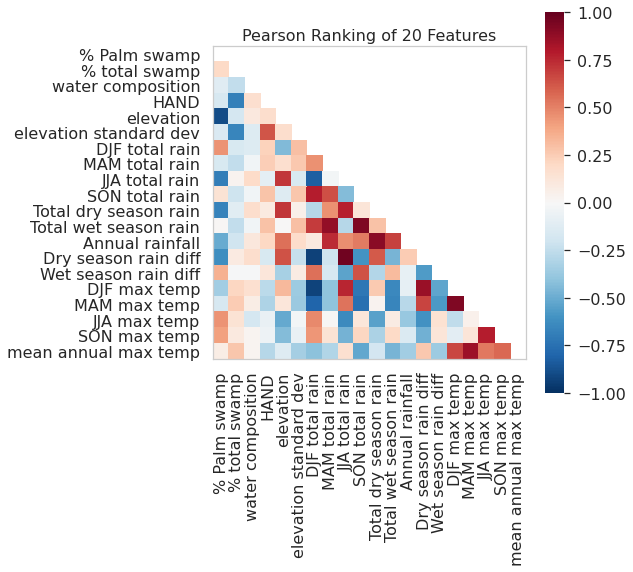

Right-bank (RoC/Mixed)


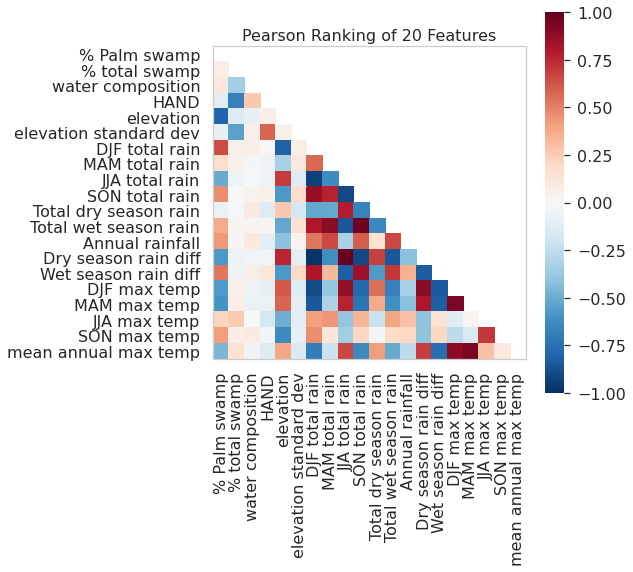

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [117]:
# Comparing DRC and Mixed/RoC correlations between palm swamp composition and different variables

df = df_ps[df_ps["combined_swamps"] > 70.0].copy()

# right hand side of Congo river
bs_right = ['basin_1','basin_2','basin_5','basin_6','basin_9','basin_10','basin_11','basin_12','basin_13']

# left-hand (DRC) side
bs_left = ['basin_3','basin_4','basin_7','basin_8']

# the variable list to be included in the correlation plots
col_names = ['PS','combined_swamps','water_composition','HAND','elevation','elevation_std','DJF','MAM','JJA','SON',
            'Total_dry_season','Total_wet_season','Annual_rainfall','Dry_diff','Wet_diff','DJF_Tmax','MAM_Tmax',
            'JJA_Tmax','SON_Tmax', 'Tmax_annual']

# the corresponding more readable variable name list to be used in the plots
col_names_new = ['% Palm swamp', '% total swamp', 'water composition',
       'HAND', 'elevation', 'elevation standard dev', 'DJF total rain', 'MAM total rain',
       'JJA total rain', 'SON total rain', 'Total dry season rain', 'Total wet season rain', 'Annual rainfall',
       'Dry season rain diff', 'Wet season rain diff', 'DJF max temp', 'MAM max temp', 'JJA max temp', 'SON max temp',
       'mean annual max temp']

df_right = df[df['basin_name'].isin(bs_right)]
df_left  = df[df['basin_name'].isin(bs_left)]

Xvis_left = df_left.copy()
yvis_left = Xvis_left['PS'].copy().values

Xvis_right = df_right.copy()
yvis_right = Xvis_right['PS'].copy().values


# setting up the plot
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

visualizer = Rank2D(algorithm='pearson')
#feature_index2 = feature_index.insert(0,'PS')
feature_index2 = col_names
col_names2=col_names_new.copy()

#col_names2 = col_names2.insert(0,'% Palm swamp composition')
print(col_names2)

print ('Left-bank (DRC)')
plt.figure(figsize=(7,7))
ax = plt.gca()
X_t=Xvis_left[feature_index2[:]]
X_t.columns = col_names2

visualizer.fit(X_t, yvis_left)           # Fit the data to the visualizer 
visualizer.transform(X_t)        # Transform the data
visualizer.show()              # Finalize and render the figure

print ('Right-bank (RoC/Mixed)')
plt.figure(figsize=(7,7))
ax = plt.gca()
visualizer = Rank2D(algorithm='pearson')
X_t=Xvis_right[feature_index2[:]]
X_t.columns = col_names2

visualizer.fit(X_t, yvis_right)           # Fit the data to the visualizer 
visualizer.transform(X_t)        # Transform the data
visualizer.show()              # Finalize and render the figure

### Define the features to be used within the regression
- for 9 RoC/Mixed (right-bank of Congo river) sub-basins

In [118]:
add = ['basin_name']

features_list = ['elevation','elevation_std','DJF','DJF_Tmax','Dry_diff','Total_wet_season','SON_Tmax','basin_name']
features_list_b = ['elevation','elevation_std','DJF','DJF_Tmax','Dry_diff','Total_wet_season','SON_Tmax']
feature_names2 = ['elevation (m)','elevation Standard dev. (m)','DJF total rainfall (mm)','DJF max temperature (\xb0C)',
                    'Dry season rainfall diff (mm)','Total wet season rainfall (mm)','SON max temperature (\xb0C)']
# only the float values:
features_num = features_list[:-1]
print ("numeric features: ", features_num)

features_all = features_list_b + bs
print(features_all)

# PS version - filtered for swamp composition > 70%
X = ps_data[features_list].reset_index().drop(columns=['index'])
#X = ps_data[features_list].reset_index().drop(columns=['index'])
y = ps_data[['PS']].reset_index().drop(columns=['index'])
y2 = (ps_data[['PS']]/100.0).reset_index().drop(columns=['index'])

#print (X.describe(include='all'))

numeric features:  ['elevation', 'elevation_std', 'DJF', 'DJF_Tmax', 'Dry_diff', 'Total_wet_season', 'SON_Tmax']
['elevation', 'elevation_std', 'DJF', 'DJF_Tmax', 'Dry_diff', 'Total_wet_season', 'SON_Tmax', 'basin_1', 'basin_2', 'basin_5', 'basin_6', 'basin_9', 'basin_10', 'basin_11', 'basin_12', 'basin_13']


### Creating the final datasets to be used within the R code and saving to csv
- The create_new_data function allows for the model consistency to be checked when using different combinations of 80/20% train/test split training data. 
- This function outputs the train and test datasets to be run within the Betareg R code (there is currently no python equivalent)

In [130]:
# function to output data with different random seed (a test was done to ensure consistency of output statistics)

def create_new_data(seed, features_list, ps_data):
    X = ps_data[features_list].reset_index().drop(columns=['index'])
    #X = ps_data[features_list].reset_index().drop(columns=['index'])
    y = ps_data[['PS']].reset_index().drop(columns=['index'])
    y2 = (ps_data[['PS']]/100.0).reset_index().drop(columns=['index'])
    
    # Defining categorical basin name columns (not dropping a sub-basin column here as this is done within the R regression algorithm)
    X_d = pd.get_dummies(data=X, drop_first=False)
    X_d['basin_name'] = X['basin_name'].values

    # sklearn implementation
    X_train, X_test, y_train, y_test = train_test_split(X_d, y2, test_size = .2, random_state =seed, stratify=X['basin_name'])

    # copies with basin_name as column - required for later plotting (lm plots)
    X_train_b = X_train.copy().reset_index()
    X_test_b = X_test.copy().reset_index()
    X_d_b = X_d.copy().reset_index()
    
    # recombining the original, test and train y and X datasets for use within the R regression algorithm
    data_all = X_d.copy()
    data_all.insert(0,'PS',y2)
    data_all = data_all.reset_index()

    data_train = X_train.copy()
    data_train.insert(0,'PS',y_train)
    data_train = data_train.reset_index()

    data_test = X_test.copy()
    data_test.insert(0,'PS',y_test)
    data_test = data_test.reset_index()
    
    # changing basin name
    ids = {'sub-basin':['basin_2','basin_3','basin_4','basin_5','basin_6','basin_7','basin_8','basin_9','basin_1','basin_13','basin_12','basin_11','basin_10'],
      'id':['Mixed 1','DRC 1','DRC 2','Mixed 2','Mixed 3','DRC 3','DRC 4','Mixed 4','RoC 1','RoC 2', 'RoC 3', 'RoC 4','RoC 5'],}

    ids = dict(zip(ids['sub-basin'],ids['id']))
    X['sub-basin'] = X['basin_name'].replace(ids)                                                                                                                                                                                                                                                                                                        
    X = X.drop(['basin_name'],axis=1)
    
    #data_all.to_csv('data_all.csv')
    #data_train.to_csv('data_train.csv')
    #data_test.to_csv('data_test.csv')
    
    data_all.to_csv('data_all_noZ.csv')
    data_train.to_csv('data_train_noZ.csv')
    data_test.to_csv('data_test_noZ.csv')
    
    print ('The training, test and all data arrays have been printed to the files:')
    print (' data_all.csv\n','data_train.csv\n','data_test.csv')
    
    return (X, X_d_b, y)
    

### Splitting the data into train and test datasets
- currently uses test size of 20% which is pretty standard
- random state usage means that the split datasets will be the same each time the code is run
- data is stratified to ensure an equal 80/20% split for each sub-basin

In [131]:
# Using the function instead of the above method - this works well
# the subset of basins (RoC and Mixed) are selected within the R code. This way the inclusion of DRC basins can 
# also be tested

# 1.STANDARDISED
df = df_ps_z[df_ps["combined_swamps"] > 70.0].copy()

#2. NON-STANDARDISED
df = df_ps[df_ps["combined_swamps"] > 70.0].copy()

# the logistic regression only works with values between, but not including, 0 and 1
df1 = df[['PS']].copy()
df1['PS'][df1['PS']==0.000000]=0.000001
df1['PS'][df1['PS']==100.0]=99.9999999
df['PS'] = df1['PS']/100.

ps_data2 = df.copy()
X, X_d_b, y = create_new_data(0, features_list, ps_data2)

The training, test and all data arrays have been printed to the files:
 data_all.csv
 data_train.csv
 data_test.csv


In [121]:
X

,elevation,elevation_std,DJF,DJF_Tmax,Dry_diff,Total_wet_season,SON_Tmax,sub-basin
0,329.757996,0.765476,205.660425,31.321197,248.804200,939.408547,30.028350,RoC 1
1,330.484222,1.788830,187.174687,31.510591,278.910206,960.960825,29.983822,RoC 1
2,332.347351,2.171438,188.682872,31.531224,273.586838,973.262786,29.876408,RoC 1
3,329.331360,1.343002,191.079334,31.505285,274.614778,964.930589,30.017157,RoC 1
4,326.702728,0.415411,209.133779,31.314179,248.658169,959.221202,30.060062,RoC 1
...,...,...,...,...,...,...,...,...
1788,312.359894,1.400438,308.474530,30.933555,50.474867,1040.940649,29.777772,RoC 2
1789,312.380829,0.662030,320.480907,30.958856,19.973519,1058.084111,29.876678,RoC 2
1790,313.815582,0.478265,313.146835,30.958329,43.194256,1054.493558,29.827907,RoC 2
1791,310.935394,1.461615,310.206109,30.855118,45.351604,1043.752402,29.713577,RoC 2


### Creating a pairplot of variable correlations for variables included in the final regression

In [132]:
# Adjusting the array layout for the pairplot figure
# This should be made with the non-z-score adjusted inputs 
X_new = X.copy()
X_new['PS'] = y
X_new2 = X_new[['PS','elevation','elevation_std','DJF','DJF_Tmax','Dry_diff','Total_wet_season','SON_Tmax','sub-basin']]
X_new2

,PS,elevation,elevation_std,DJF,DJF_Tmax,Dry_diff,Total_wet_season,SON_Tmax,sub-basin
0,0.000040,329.757996,0.765476,205.660425,31.321197,248.804200,939.408547,30.028350,RoC 1
1,0.000042,330.484222,1.788830,187.174687,31.510591,278.910206,960.960825,29.983822,RoC 1
2,0.000046,332.347351,2.171438,188.682872,31.531224,273.586838,973.262786,29.876408,RoC 1
3,0.000081,329.331360,1.343002,191.079334,31.505285,274.614778,964.930589,30.017157,RoC 1
4,0.000119,326.702728,0.415411,209.133779,31.314179,248.658169,959.221202,30.060062,RoC 1
...,...,...,...,...,...,...,...,...,...
1788,0.968192,312.359894,1.400438,308.474530,30.933555,50.474867,1040.940649,29.777772,RoC 2
1789,0.968672,312.380829,0.662030,320.480907,30.958856,19.973519,1058.084111,29.876678,RoC 2
1790,0.971660,313.815582,0.478265,313.146835,30.958329,43.194256,1054.493558,29.827907,RoC 2
1791,0.978172,310.935394,1.461615,310.206109,30.855118,45.351604,1043.752402,29.713577,RoC 2


CPU times: user 28.8 s, sys: 333 ms, total: 29.1 s
Wall time: 28.7 s


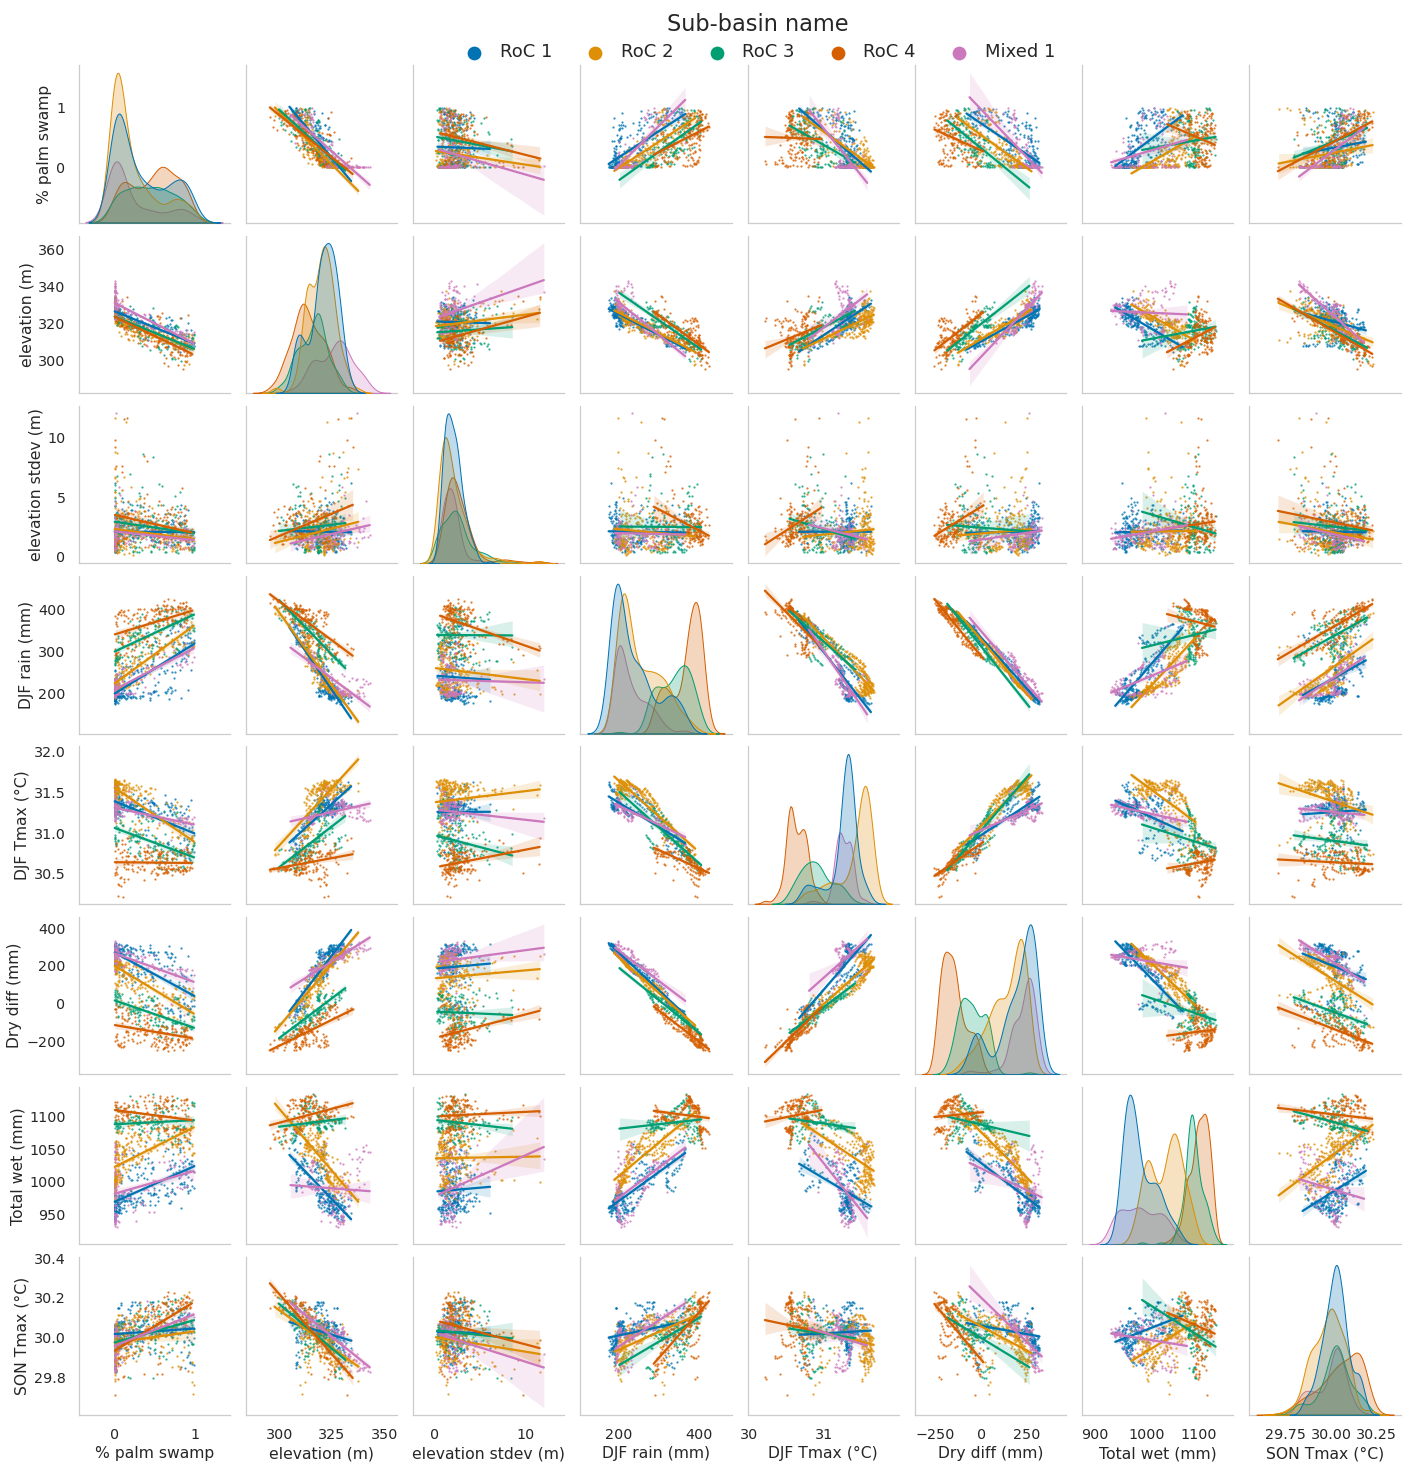

In [133]:
%%time
# Paper figure
# *** Note - use non-standardised values ***
#train_dataset = X_train.copy()
#train_dataset.insert(0, "PS", y_train)
y_new = y*100
full_dataset = X_new2.copy()
bs2 = ['RoC 1', 'RoC 2','RoC 3', 'RoC 4','Mixed 1']
#bs2 = ['Mixed 1','Mixed 2','Mixed 3','Mixed 4']
#full_dataset.insert(0, "% PS", y_new)
#full_dataset.insert(0, "PS", y2)
#'log(PS/(1-PS))'
#full_dataset.columns = ['% PS','elevation','DJF accum (mm)','Dry diff (mm)','Dry_ratio','Wet_ratio','Wet diff (mm)','JJA','SON','TWS','Annual rainfall (mm)','basin_name']
#full_dataset.columns = ['% PS','elevation (m)','elevation_var (m)','DJF accum (mm)','Dry diff (mm)','SON accum (mm)','Wet diff (mm)','sub-basin']
full_dataset.columns = ['% palm swamp','elevation (m)','elevation stdev (m)','DJF rain (mm)','DJF Tmax (\xb0C)',
                    'Dry diff (mm)','Total wet (mm)','SON Tmax (\xb0C)','sub-basin']

#full_dataset.columns = ['% PS','elevation','DJF_Tmax','MAM_Tmax','SON_Tmax','Tdiff_MAM_JJA','Tdiff_SON_DJF','sub-basin']
g = sns.pairplot(full_dataset, kind='reg', corner=False, plot_kws=dict(scatter_kws=dict(s=5)), 
                 diag_kind='auto', hue='sub-basin', hue_order=bs2)
g._legend.set_title("Sub-basin name", prop={'size':'x-large'})

for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [190]
    
# move default legend location
sns.move_legend(g,ncol=len(bs2), loc='upper center',bbox_to_anchor=(0.5,1.03)) 
plt.setp(g._legend.get_texts(),fontsize='18')

# setting 0 to 100% limit for % PS
#g.axes[0,0].set_xlim((-25,125))
#g.axes[0,4].set_ylim((0,100))

sns.set(font_scale = 1.3, style='whitegrid')
sns.set_palette("colorblind")
sns.set_style("whitegrid", {'axes.grid' : False})

#sns.set_context("notebook", rc={"axes.labelsize":16})

In [126]:
full_dataset

,% palm swamp,elevation (m),elevation stdev (m),DJF rain (mm),DJF Tmax (°C),Dry diff (mm),Total wet (mm),SON Tmax (°C),sub-basin
0,0.000040,329.757996,0.765476,205.660425,31.321197,248.804200,939.408547,30.028350,RoC 1
1,0.000042,330.484222,1.788830,187.174687,31.510591,278.910206,960.960825,29.983822,RoC 1
2,0.000046,332.347351,2.171438,188.682872,31.531224,273.586838,973.262786,29.876408,RoC 1
3,0.000081,329.331360,1.343002,191.079334,31.505285,274.614778,964.930589,30.017157,RoC 1
4,0.000119,326.702728,0.415411,209.133779,31.314179,248.658169,959.221202,30.060062,RoC 1
...,...,...,...,...,...,...,...,...,...
1788,NaN,312.359894,1.400438,308.474530,30.933555,50.474867,1040.940649,29.777772,RoC 2
1789,NaN,312.380829,0.662030,320.480907,30.958856,19.973519,1058.084111,29.876678,RoC 2
1790,NaN,313.815582,0.478265,313.146835,30.958329,43.194256,1054.493558,29.827907,RoC 2
1791,NaN,310.935394,1.461615,310.206109,30.855118,45.351604,1043.752402,29.713577,RoC 2


### The Beta_regression.ipynb R code was used to apply the beta regression and predict the outputs for data_all, data_train and data_test
- now reading the outputs from the R code back into python for plotting

In [33]:
# datasets with added prediction columns
# model with all variable inputs - standardised
data_all_p = pd.read_csv('data_all_predict.csv')
data_train_p = pd.read_csv('data_train_predict.csv')
data_test_p = pd.read_csv('data_test_predict.csv')

# model with elevation + DJF + Dry_diff + Wet_diff + SON - not standardised
#data_all_p = pd.read_csv('data_all_predict_noZ.csv')
#data_train_p = pd.read_csv('data_train_predict_noZ.csv')
#data_test_p = pd.read_csv('data_test_predict_noZ.csv')

# model with DJF + Dry_diff + Wet_diff + SON
#data_all_p2 = pd.read_csv('data_all_predict2.csv')
#data_train_p2 = pd.read_csv('data_train_predict2.csv')
#data_test_p2 = pd.read_csv('data_test_predict2.csv')

In [63]:
data_test_p.columns

Index(['X', 'index', 'PS', 'elevation', 'R_diff2', 'R_diff1', 'DJF', 'lat_cat',
       'Tdiff_MAM_JJA', 'Tdiff_SON_DJF', 'MAM_Tmax', 'Dry_ratio', 'Dry_diff',
       'DJF_Tmax', 'Wet_ratio', 'Wet_diff', 'R_diff4', 'JJA', 'R_diff3', 'SON',
       'Annual_rainfall', 'SON_Tmax', 'Total_wet_season', 'JJA_Tmax',
       'Tdiff_DJF_MAM', 'MAM', 'HAND', 'elevation_var', 'water_composition',
       'elevation_std', 'Total_dry_season', 'basin', 'Tdiff_JJA_SON',
       'basin_name_basin_1', 'basin_name_basin_10', 'basin_name_basin_11',
       'basin_name_basin_12', 'basin_name_basin_13', 'basin_name_basin_2',
       'basin_name_basin_3', 'basin_name_basin_4', 'basin_name_basin_5',
       'basin_name_basin_6', 'basin_name_basin_7', 'basin_name_basin_8',
       'basin_name_basin_9', 'basin_name', 'Prediction'],
      dtype='object')

#### Plotting the predictions and statistics

basin_1 MAE: 8.7 rRMSE: 15.9% R²: 0.766
basin_2 MAE: 4.5 rRMSE: 11.9% R²: 0.859
basin_5 MAE: 6.8 rRMSE: 11.2% R²: 0.802
basin_6 MAE: 8.5 rRMSE: 18.9% R²: 0.76
basin_9 MAE: 14.8 rRMSE: 18.7% R²: 0.57
basin_10 MAE: 11.2 rRMSE: 14.8% R²: 0.816
basin_11 MAE: 10.4 rRMSE: 17.1% R²: 0.637
basin_12 MAE: 10.5 rRMSE: 18.5% R²: 0.596
basin_13 MAE: 8.0 rRMSE: 13.3% R²: 0.782


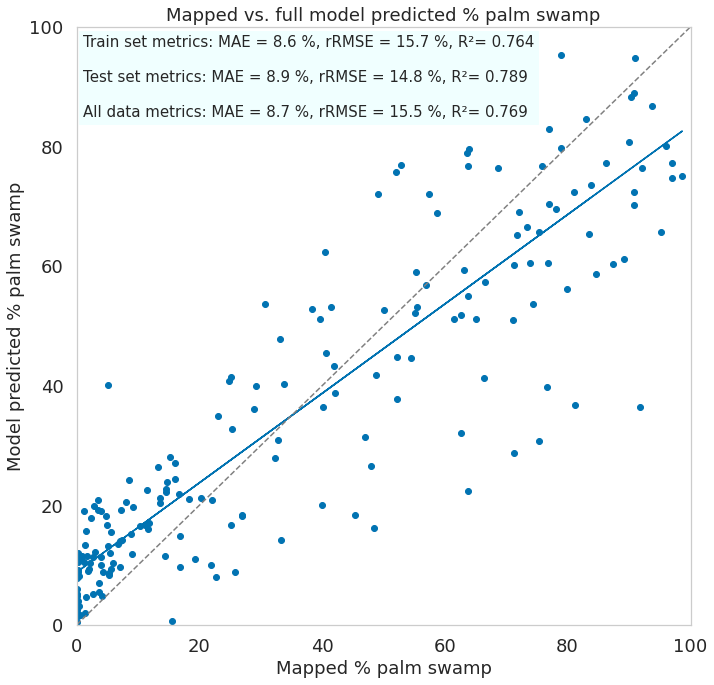

In [40]:
# Plotting the test data - model vs. mapped
# underestimates at high % ps, and overestimates at low % ps.
bs = ['basin_1','basin_2','basin_5','basin_6','basin_9','basin_10','basin_11','basin_12','basin_13']
data_test_p2 = data_test_p[data_test_p['basin_name'].isin(bs)]
data_train_p2 = data_train_p[data_train_p['basin_name'].isin(bs)]
data_all_p2 = data_all_p[data_all_p['basin_name'].isin(bs)]

# training data
y_train_orig = 100*data_train_p2['PS']
y_train_pred = 100*data_train_p2['Prediction']

# test data
y_test_orig = 100*data_test_p2['PS']
y_test_pred = 100*data_test_p2['Prediction']

# Full dataset
y_all_orig = 100*data_all_p2['PS']
y_all_pred = 100*data_all_p2['Prediction']

# train data stats
mae = median_absolute_error(y_train_orig, y_train_pred)
rmse = np.sqrt(mean_squared_error(y_train_orig, y_train_pred))
r2 = r2_score(y_train_orig, y_train_pred)
string_score = f'Train set metrics: MAE = {mae:.1f} %, rRMSE = {rmse:.1f} %, R\N{SUPERSCRIPT TWO}= {r2:.3f}\n\n'


# test data stats
mae = median_absolute_error(y_test_orig, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred))
r2 = r2_score(y_test_orig, y_test_pred)
string_score += f'Test set metrics: MAE = {mae:.1f} %, rRMSE = {rmse:.1f} %, R\N{SUPERSCRIPT TWO}= {r2:.3f}\n\n'

# Full data stats
mae = median_absolute_error(y_all_orig, y_all_pred)
rmse = np.sqrt(mean_squared_error(y_all_orig, y_all_pred))
r2 = r2_score(y_all_orig, y_all_pred)
string_score += f'All data metrics: MAE = {mae:.1f} %, rRMSE = {rmse:.1f} %, R\N{SUPERSCRIPT TWO}= {r2:.3f}'

# calculating the median absolute error across all data for each basin individually
basin_mae = []
basin_rmse = []
basin_r2 = []

for i in range(len(bs)):
    # all data (X)
    yorig = y_all_orig[data_all_p['basin_name']==bs[i]]
    # previously X_d_b instead of data_all_p
    ynew = y_all_pred[data_all_p['basin_name']==bs[i]]
    
    mae_b = np.around(median_absolute_error(yorig,ynew),1)
    rmse_b = np.around(np.sqrt(mean_squared_error(yorig,ynew)),1)
    r2_b = np.around(r2_score(yorig,ynew),3)
    print (bs[i] + " MAE: " + str(mae_b) + " rRMSE: " + str(rmse_b) + "% R\N{SUPERSCRIPT TWO}: " + str(r2_b) )
    basin_mae.append(mae_b)
    basin_rmse.append(rmse_b)
    basin_r2.append(r2_b)
    
# scatter plot of test dataset predicted vs. mapped
fig, ax = plt.subplots(figsize=(11, 11))
#c_list = ['#ffffbf','#abd9e9','#d7191c','#2c7bb6','#fdae61']

#colors = {'basin_1':c_list[0],'basin_2':c_list[1],'basin_11':c_list[2],'basin_12':c_list[3],'basin_13':c_list[4]}

import matplotlib.patches as mpatches
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# R2 text for individual basins
#b1 = mpatches.Patch(color=c_list[0], label='basin 1, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[0]))
#b2 = mpatches.Patch(color=c_list[1], label='basin 2, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[1]))
#b3 = mpatches.Patch(color=c_list[2], label='basin 11, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[2]))
#b4 = mpatches.Patch(color=c_list[3], label='basin 12, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[3]))
#b5 = mpatches.Patch(color=c_list[4], label='basin 13, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[4]))

#legend_b = [b1,b2,b3,b4,b5]
#legend_b = [b1,b2]
#legend_b = [b3,b4,b5]
#plt.legend(handles=legend_b, prop={'size':14},loc=2)


plt.scatter(y_test_orig, y_test_pred)  # test dataset single colour
#plt.scatter(y_all_orig, y_all_pred,c=X['basin_name'].map(colors))      # all data
# adding linear regression line
m, b = np.polyfit(y_test_orig, y_test_pred, 1)
plt.plot(y_test_orig, m*y_test_orig + b)

small = 12
med = 15
large = 18

plt.rc('font', size=med)          # controls default text sizes
plt.rc('axes', titlesize=large)     # fontsize of the axes title
plt.rc('axes', labelsize=large)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=large)    # fontsize of the tick labels
plt.rc('ytick', labelsize=large)    # fontsize of the tick labels
plt.rc('legend', fontsize=large, facecolor='gray')    # legend fontsize
plt.rc('figure', titlesize=large)  # fontsize of the figure title

plt.plot([0, 100], [0, 100], transform=ax.transAxes, ls="--", c="grey")
#ax.xaxis.set_minor_locator(MultipleLocator(5))
plt.text(1,85, string_score, backgroundcolor='azure')
plt.title('Mapped vs. full model predicted % palm swamp')
plt.ylabel('Model predicted % palm swamp')
plt.xlabel('Mapped % palm swamp')
plt.xlim([0, 100]) 
plt.ylim([0, 100])
plt.grid(False)
# Annual rainfall as parameter (stats across all basins)
#basin_1 MAE: 6.5 rRMSE: 17.1% R²: 0.729
#basin_2 MAE: 3.4 rRMSE: 14.5% R²: 0.803
#basin_11 MAE: 8.9 rRMSE: 19.3% R²: 0.537
#basin_12 MAE: 9.9 rRMSE: 17.6% R²: 0.631
#basin_13 MAE: 4.3 rRMSE: 18.0% R²: 0.613

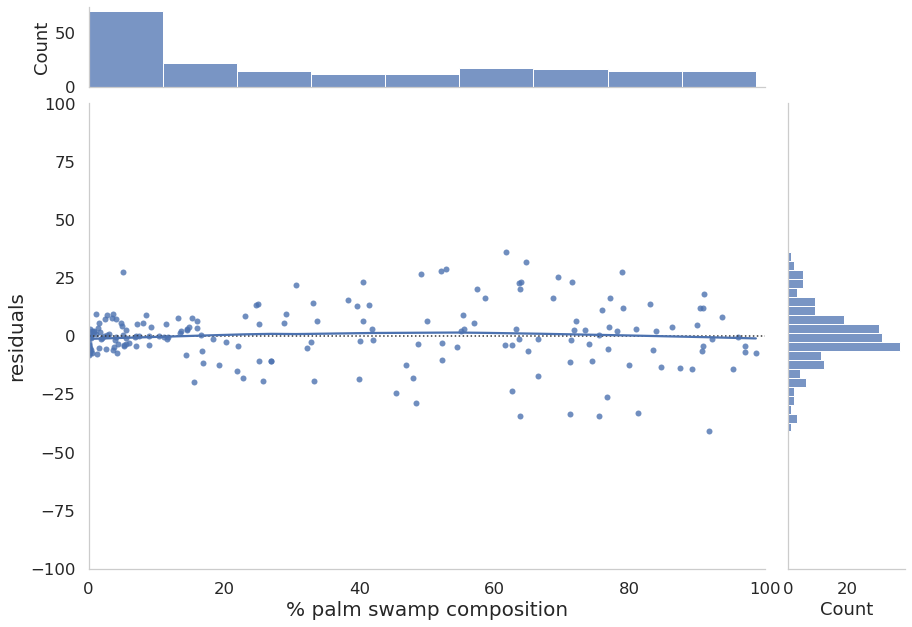

In [44]:
# Plotting a residual plot with histogram
bs = ['basin_2','basin_1','basin_13','basin_12','basin_11']
df = data_test_p.copy()
#df =df[df['basin_name'].isin(bs)]

# renaming sub-basins
ids = {'sub-basin':['basin_2','basin_1','basin_13','basin_12','basin_11'],
      'id':['DRC 1','RoC 1','RoC 2', 'RoC 3', 'RoC 4'],}

ids = dict(zip(ids['sub-basin'],ids['id']))
df['sub-basin'] = df['basin_name'].replace(ids)
df['PS'] = 100*df['PS']
df['Prediction'] = 100*df['Prediction']
df['Residuals'] = df['PS'] - df['Prediction']
# ordering by sub-basin in ascending order - required for the output plots to be in order.
df = df.sort_values(by=['sub-basin'])

# plotting 
sns.set(font_scale = 1.5,style='whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.jointplot(data=df,x="PS",y='Prediction',ax=True,kind='resid',marginal_ticks=True,lowess=True)
ax.fig.set_figwidth(15)
ax.fig.set_figheight(10)
ax.ax_marg_x.set_xlim(0, 100)
ax.ax_marg_y.set_ylim(-100,100)
ax.set_axis_labels('% palm swamp composition', 'residuals', fontsize=20)


In [80]:
# Identifying where the outliers arise using the full dataset, 748 obs
# Plotting a residual plot with histogram

df = data_test_p.copy()

# renaming sub-basins
ids = {'sub-basin':['basin_2','basin_5','basin_6','basin_9','basin_1','basin_13','basin_12','basin_11','basin_10'],
      'id':['Mixed 1','Mixed 2','Mixed 3','Mixed 4','RoC 1','RoC 2', 'RoC 3', 'RoC 4','RoC 5'],}

ids = dict(zip(ids['sub-basin'],ids['id']))
df['sub-basin'] = df['basin_name'].replace(ids)
df['PS'] = 100*df['PS']
df['Prediction'] = 100*df['Prediction']
df['Residuals'] = df['PS'] - df['Prediction']
# ordering by sub-basin in ascending order - required for the output plots to be in order.
df = df.sort_values(by=['sub-basin'])

df

,X,index,PS,elevation,R_diff2,R_diff1,DJF,lat_cat,Tdiff_MAM_JJA,Tdiff_SON_DJF,...,basin_name_basin_4,basin_name_basin_5,basin_name_basin_6,basin_name_basin_7,basin_name_basin_8,basin_name_basin_9,basin_name,Prediction,sub-basin,Residuals
124,231,340,25.8328,0.000705,1.299699,-1.213455,-1.626458,1.353915,-1.063031,1.357409,...,0,0,0,0,0,0,basin_2,8.820877,Mixed 1,17.011923
132,247,277,0.0737,0.337502,1.369069,-1.265769,-1.668837,1.472310,-1.129330,1.526326,...,0,0,0,0,0,0,basin_2,3.264706,Mixed 1,-3.191006
109,209,317,2.7074,-0.094623,0.952445,-0.704792,-1.288511,1.117126,-0.896778,1.039507,...,0,0,0,0,0,0,basin_2,11.402715,Mixed 1,-8.695315
108,207,276,0.0737,0.645677,1.529770,-1.402248,-1.550074,1.413113,-0.855063,1.524916,...,0,0,0,0,0,0,basin_2,3.131076,Mixed 1,-3.057376
46,99,343,32.8381,-0.162532,1.091403,-0.842069,-1.332339,1.176323,-0.955145,1.146499,...,0,0,0,0,0,0,basin_2,30.830935,Mixed 1,2.007165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,278,1342,63.1779,-0.923369,-0.299471,0.281890,0.360920,-0.185216,0.316359,-0.810160,...,0,0,0,0,0,0,basin_11,59.265645,RoC 4,3.912255
157,286,1261,15.5583,0.489374,0.755646,-1.020813,-0.575286,0.495553,-0.473248,0.509232,...,0,0,0,0,0,0,basin_11,0.634463,RoC 4,14.923837
167,301,1319,55.2987,-0.751398,-0.081872,-0.128810,0.257057,-0.007624,0.286365,-0.575526,...,0,0,0,0,0,0,basin_11,59.045714,RoC 4,-3.747014
24,64,1221,4.9099,-0.246684,0.930337,-0.662787,-0.846213,0.791540,-0.788878,1.249544,...,0,0,0,0,0,0,basin_10,16.754731,RoC 5,-11.844831


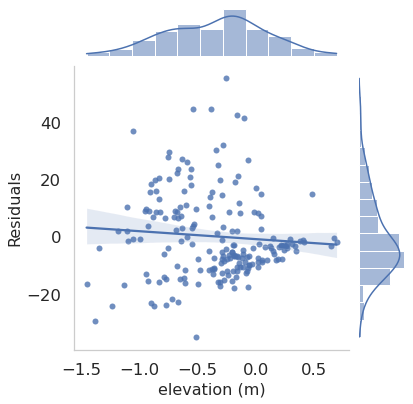

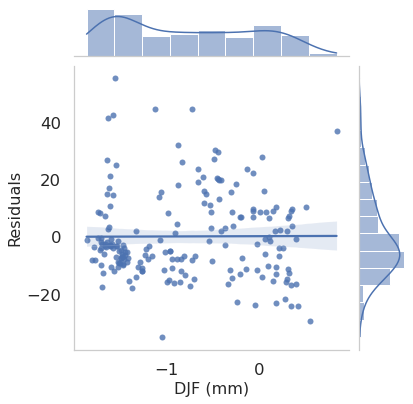

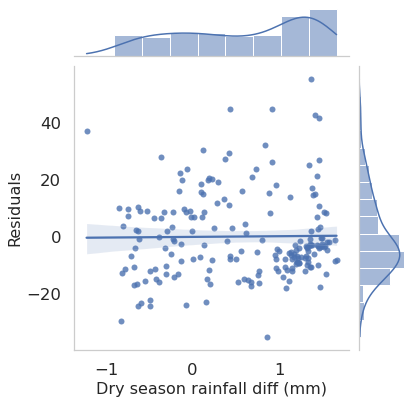

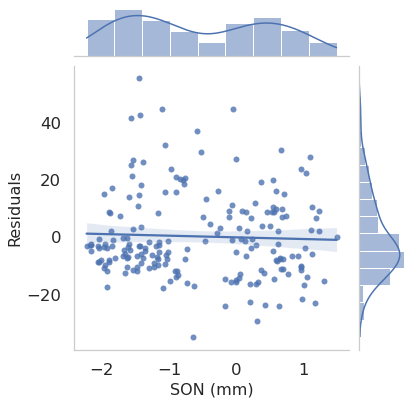

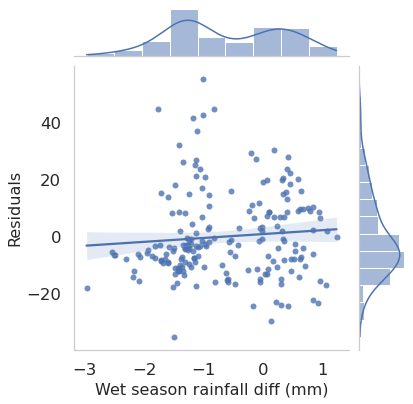

In [46]:
# testing the relationship between the residuals and different variables. 

ax = sns.jointplot(data=df,x="elevation",y='Residuals',kind="reg")
ax.set_axis_labels('elevation (m)', 'Residuals', fontsize=16)

#ax = sns.jointplot(data=df,x="elevation",y='Residuals',kind='kde',fill=False, joint_kws={'alpha': 0.65})
#ax = sns.jointplot(data=df,x="elevation",y='Residuals')
ax.ax_marg_x.set_axis_off()
ax.ax_marg_y.set_axis_off()
# rainfall parameters
ax = sns.jointplot(data=df,x="DJF",y='Residuals',kind='reg')
ax.set_axis_labels('DJF (mm)', 'Residuals', fontsize=16)

ax = sns.jointplot(data=df,x="Dry_diff",y='Residuals',kind='reg')
ax.set_axis_labels('Dry season rainfall diff (mm)', 'Residuals', fontsize=16)

ax = sns.jointplot(data=df,x="SON",y='Residuals',kind='reg')
ax.set_axis_labels('SON (mm)', 'Residuals', fontsize=16)

ax = sns.jointplot(data=df,x="Wet_diff",y='Residuals',kind='reg')
ax.set_axis_labels('Wet season rainfall diff (mm)', 'Residuals', fontsize=16)

#ax = sns.jointplot(data=df2,x="Annual_rainfall",y='Residuals',kind='reg')
#ax.set_axis_labels('Annual rainfall total (mm)', 'Residuals', fontsize=16)

#ax = sns.jointplot(data=df2,x="Total_wet_season",y='Residuals',kind='reg')
#ax.set_axis_labels('Wet season rainfall total (mm)', 'Residuals', fontsize=16)

#ax = sns.jointplot(data=df2,x="T",y='Residuals',kind='reg')
#ax.set_axis_labels('Wet season rainfall total (mm)', 'Residuals', fontsize=16)


196


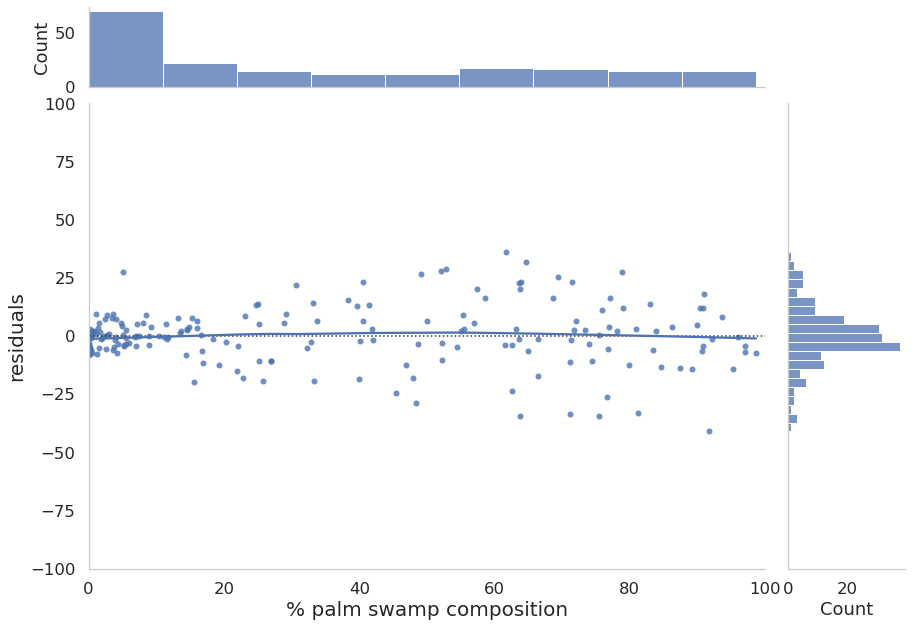

In [73]:
# Plotting a residual plot with histogram

df = data_test_p.copy()

ids = {'sub-basin':['basin_2','basin_5','basin_6','basin_9','basin_1','basin_13','basin_12','basin_11','basin_10'],
      'id':['Mixed 1','Mixed 2','Mixed 3','Mixed 4','RoC 1','RoC 2', 'RoC 3', 'RoC 4','RoC 5'],}

ids = dict(zip(ids['sub-basin'],ids['id']))
df['sub-basin'] = df['basin_name'].replace(ids)
df['PS'] = 100*df['PS']
df['Prediction'] = 100*df['Prediction']
df['Residuals'] = df['PS'] - df['Prediction']

print (len(df))

# ordering by sub-basin in ascending order - required for the output plots to be in order.
df = df.sort_values(by=['sub-basin'])


# plotting 

ax = sns.jointplot(data=df,x="PS",y='Prediction',ax=True,kind='resid',marginal_ticks=True,lowess=True)
ax.fig.set_figwidth(15)
ax.fig.set_figheight(10)
ax.ax_marg_x.set_xlim(0, 100)
ax.ax_marg_y.set_ylim(-100,100)
ax.set_axis_labels('% palm swamp composition', 'residuals', fontsize=20)


In [90]:
df_new = pd.DataFrame({"true % palm swamp":100*data_all_p['PS'],"predicted % palm swamp":100*data_all_p['Prediction'],'basin_name':data_all_p['basin_name']})
# renaming sub-basins
ids = {'sub-basin':['basin_2','basin_5','basin_6','basin_9','basin_1','basin_13','basin_12','basin_11','basin_10'],
      'id':['Mixed 1','Mixed 2','Mixed 3','Mixed 4','RoC 1','RoC 2', 'RoC 3', 'RoC 4','RoC 5'],}

ids = dict(zip(ids['sub-basin'],ids['id']))
df_new['sub-basin'] = df_new['basin_name'].replace(ids)

# ordering by sub-basin in ascending order - required for the output plots to be in order.
df_new = df_new.sort_values(by=['sub-basin'])
print(df_new)
df = df_new.copy()
df['sub-basin'] = pd.Categorical(df['sub-basin'],categories=['RoC 1','RoC 2', 'RoC 3', 'RoC 4','RoC 5','Mixed 1','Mixed 2','Mixed 3','Mixed 4'])
df = df.sort_values('sub-basin')
df

     true % palm swamp  predicted % palm swamp basin_name sub-basin
327             5.2813                8.371264    basin_2   Mixed 1
312             1.4905                4.661644    basin_2   Mixed 1
311             1.3195                4.800635    basin_2   Mixed 1
310             1.3114                9.851178    basin_2   Mixed 1
309             1.3024                3.952763    basin_2   Mixed 1
..                 ...                     ...        ...       ...
411            74.0895               93.493412   basin_10     RoC 5
410            64.2714               91.528110   basin_10     RoC 5
409             4.9099               16.754731   basin_10     RoC 5
408             0.1832                5.479820   basin_10     RoC 5
415            89.8509               75.809858   basin_10     RoC 5

[981 rows x 4 columns]


,true % palm swamp,predicted % palm swamp,basin_name,sub-basin
75,4.9845,8.606061,basin_1,RoC 1
69,3.9213,14.780569,basin_1,RoC 1
70,4.1961,4.740052,basin_1,RoC 1
71,4.1982,4.974004,basin_1,RoC 1
72,4.3504,8.836116,basin_1,RoC 1
...,...,...,...,...
399,22.7412,6.812774,basin_9,Mixed 4
401,39.6488,59.506775,basin_9,Mixed 4
400,27.6650,33.912706,basin_9,Mixed 4
398,1.6401,11.586756,basin_9,Mixed 4


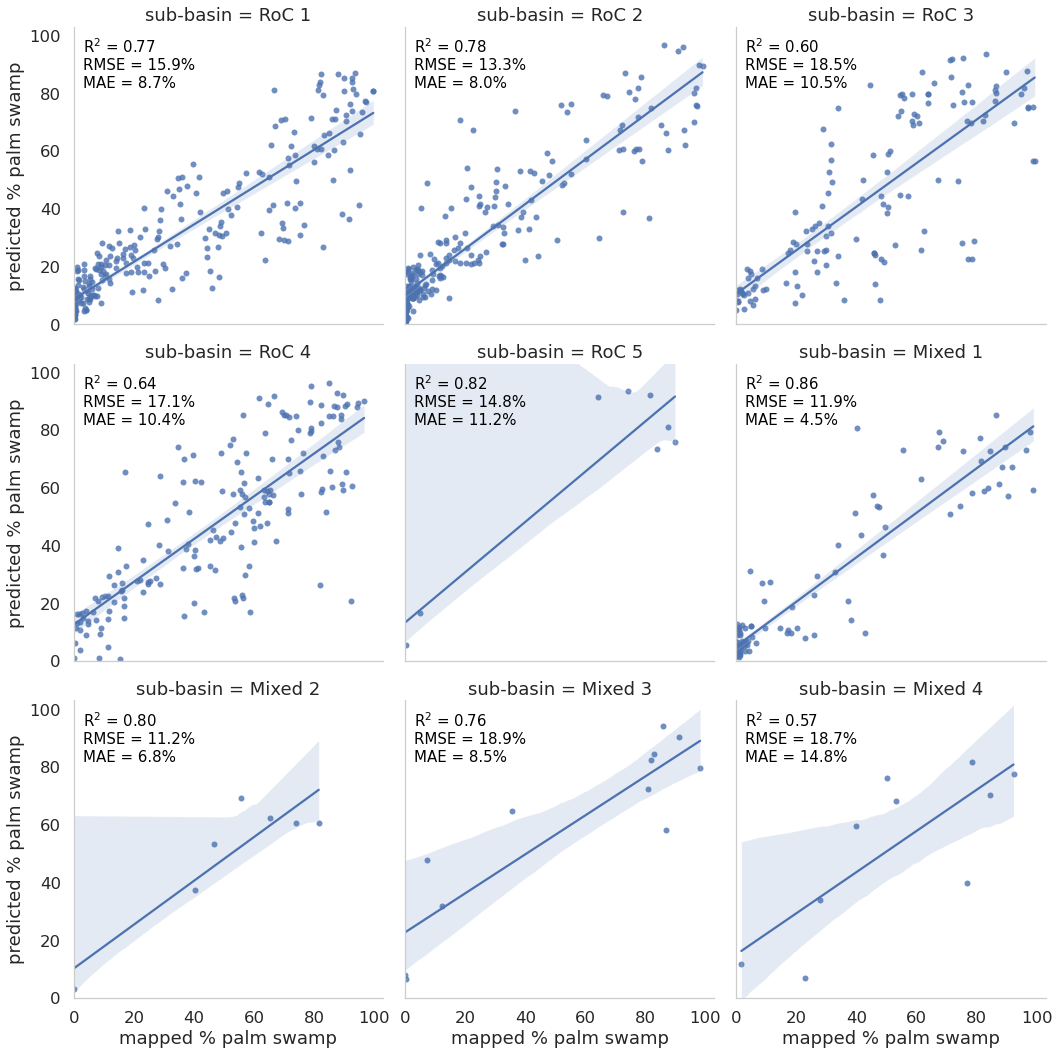

In [91]:
# figure in final paper
#g = sns.lmplot(x='true % palm swamp', y='predicted % palm swamp', hue = 'sub-basin', col = 'sub-basin', col_wrap=3, data=df, legend=True, palette=sns.color_palette("colorblind"))

g = sns.lmplot(x='true % palm swamp', y='predicted % palm swamp', col = 'sub-basin', col_wrap=3, data=df, legend=True)
g.set(ylim=(0,103))
g.set(xlim=(0,103))

# R2 array
#basin_1 MAE: 8.7 rRMSE: 15.9% R²: 0.766  # RoC1
#basin_2 MAE: 4.5 rRMSE: 11.9% R²: 0.859  # Mixed1
#basin_5 MAE: 6.8 rRMSE: 11.2% R²: 0.802  # Mixed2
#basin_6 MAE: 8.5 rRMSE: 18.9% R²: 0.76   # Mixed3
#basin_9 MAE: 14.8 rRMSE: 18.7% R²: 0.57  # Mixed4
#basin_10 MAE: 11.2 rRMSE: 14.8% R²: 0.816 # RoC5
#basin_11 MAE: 10.4 rRMSE: 17.1% R²: 0.637 # RoC4
#basin_12 MAE: 10.5 rRMSE: 18.5% R²: 0.596 # ROC3
#basin_13 MAE: 8.0 rRMSE: 13.3% R²: 0.782  # ROC2

r2_values = ['0.77','0.78','0.60','0.64','0.82','0.86','0.80','0.76','0.57']
RMSE_values = ['15.9','13.3','18.5','17.1','14.8','11.9','11.2','18.9','18.7']
MAE_values = ['8.7','8.0','10.5','10.4','11.2','4.5','6.8','8.5','14.8']

# add text annotations of the R2 value
for i in range(9):
    ax = g.axes[i]
    ax.text(3, 82, "R$^2$ = " + r2_values[i] + '\nRMSE = ' + RMSE_values[i] + '%\nMAE = ' + MAE_values[i] + '%', horizontalalignment='left', size='small', color='black', weight='normal')

g.set(xlabel='mapped % palm swamp')

#### Setting up a beta regression model in python - using R instead as it's not clear what the input data format should be)
- following the example code provided by Christian Graf: https://towardsdatascience.com/a-guide-to-the-regression-of-rates-and-proportions-bcfe1c35344f

#### Coefficient importance plot

In [76]:
# test data
df_new = pd.DataFrame({"true % palm swamp":100*data_test_p['PS'],"predicted % palm swamp":100*data_test_p['Prediction'],'basin_name':data_test_p['basin_name']})

# renaming sub-basins
ids = {'sub-basin':['basin_2','basin_5','basin_6','basin_9','basin_1','basin_13','basin_12','basin_11','basin_10'],
      'id':['Mixed 1','Mixed 2','Mixed 3','Mixed 4','RoC 1','RoC 2', 'RoC 3', 'RoC 4','RoC 5'],}

ids = dict(zip(ids['sub-basin'],ids['id']))
df_new['sub-basin'] = df_new['basin_name'].replace(ids)


# ordering by sub-basin in ascending order - required for the output plots to be in order.
df_new = df_new.sort_values(by=['sub-basin'])
df_final = df_new[df_new['sub-basin'].isin(['RoC 1','RoC 2','RoC 3','RoC 4','Mixed 1'])]

# R2 text for individual basins
c_list = ['#FAEED9','#0173B2','#CE7DBE','#DA782A','#5DC0A5','#CE7DBE','#DA782A','#5DC0A5','#5DC0A5']

b1 = mpatches.Patch(color=c_list[1], label='Mixed 1, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[1]))
b2 = mpatches.Patch(color=c_list[0], label='RoC 1, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[0]))
b3 = mpatches.Patch(color=c_list[4], label='RoC 2, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[4]))
b4 = mpatches.Patch(color=c_list[3], label='RoC 3, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[3]))
b5 = mpatches.Patch(color=c_list[2], label='RoC 4, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[2]))
#b6 = mpatches.Patch(color=c_list[5], label='Mixed 1, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[5]))
#b7 = mpatches.Patch(color=c_list[6], label='Mixed 2, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[6]))
#b8 = mpatches.Patch(color=c_list[7], label='Mixed 3, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[7]))
#b9 = mpatches.Patch(color=c_list[8], label='RoC 5, R\N{SUPERSCRIPT TWO} = ' + str(basin_r2[8]))
#legend_b = [b1,b2,b3,b4,b5,b6,b7,b8,b9]
legend_b = [b1,b2,b3,b4,b5]
#legend_b = [b1,b2]
#legend_b = [b3,b4,b5]
plt.legend(handles=legend_b, prop={'size':14},loc='center left', bbox_to_anchor=(1, 0.5))

g = sns.lmplot(x='true % palm swamp', y='predicted % palm swamp', hue = 'sub-basin', col = 'sub-basin', col_wrap=3, data=df_final, fit_reg=True, robust=True,truncate=True, legend=True, palette=sns.color_palette("colorblind"))
# overplotting a 1:1 line
X_plot = np.linspace(0,100,100)
Y_plot = X_plot.copy()

#plt.plot(X_plot,Y_plot,color='gray',linestyele='dashed')
#g.set(ylim=(0,100))
#g.set(xlim=(0,100))



IndexError: list index out of range

AttributeError: 'JointGrid' object has no attribute 'get_legend'

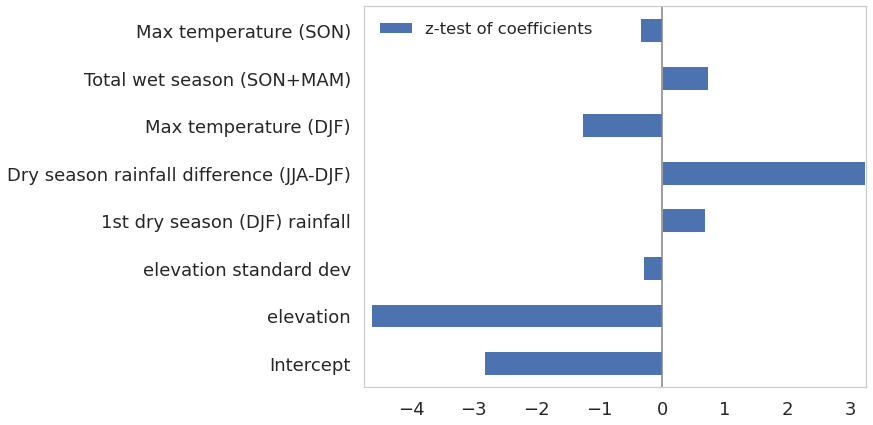

In [77]:
# new
# taking the coefficient outputs from the Beta_regression.ipynb R code
#https://stats.stackexchange.com/questions/297659/interpretation-of-betareg-coef
#https://stats.stackexchange.com/questions/442789/interpretation-of-the-beta-regression-coefficients-with-logit-link-used-to-analy

feature_names3=['Intercept','elevation','elevation standard dev','1st dry season (DJF) rainfall','Dry season rainfall difference (JJA-DJF)',
               'Max temperature (DJF)','Total wet season (SON+MAM)','Max temperature (SON)']

#coeffs = [-12.898,-21.598,3.500,9.889,4.763,5.544]  # z-value
coeffs = [-2.832110,-4.639456,-0.298973,0.672975,3.230571,-1.284508,0.726320,-0.353391] # coeffs
coefs = pd.DataFrame(
    coeffs,
    columns=['z-test of coefficients'], index=feature_names3)

coefs.plot(kind="barh", figsize=(9, 7),fontsize=18, xlim=(-4.75,3.25))
#plt.title("feature importance - model includes elevation + rainfall features")
plt.axvline(x=0, color=".5")
ax.get_legend().remove()
plt.grid(False)
plt.subplots_adjust(left=0.3)

AttributeError: 'JointGrid' object has no attribute 'get_legend'

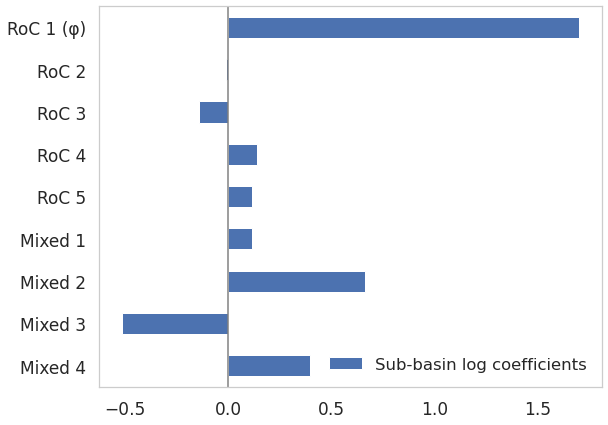

In [79]:
# sub basin coefficients
# taking the coefficient outputs from the Beta_regression.ipynb R code

#feature_names3=['RoC 1','RoC 2','RoC 3','RoC 4','RoC 5','Mixed 1','Mixed 2','Mixed 3','Mixed 4']
feature_names3=['Mixed 4','Mixed 3','Mixed 2','Mixed 1','RoC 5','RoC 4','RoC 3','RoC 2','RoC 1 (\u03C6)']

#coeffs = [-12.898,-21.598,3.500,9.889,4.763,5.544]  # z-value
#coeffs = [1.701097,-0.012723,-0.142299,0.138843,0.115342,0.117807,0.663889,-0.513539,0.398836] # coeffs
coeffs = [0.398836,-0.513539,0.663889,0.117807,0.115342,0.138843,-0.142299,-0.012723,1.701097,]
coefs = pd.DataFrame(
    coeffs,
    columns=['Sub-basin log coefficients'], index=feature_names3)

coefs.plot(kind="barh", figsize=(9, 7),fontsize=17)
#plt.title("feature importance - model includes elevation + rainfall features")
plt.axvline(x=0, color=".5")
plt.grid(False)
ax.get_legend().remove()
plt.subplots_adjust(left=0.3)

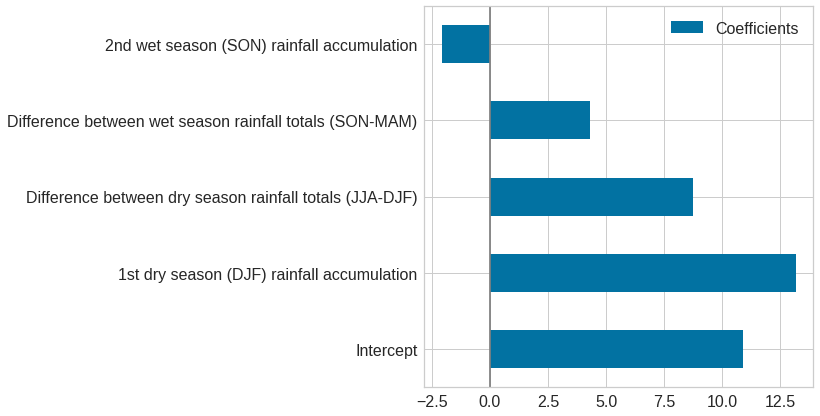

In [51]:
# Beta regression without taking elevation into consideration

feature_names3=['Intercept','1st dry season (DJF) rainfall accumulation','Difference between dry season rainfall totals (JJA-DJF)',
               'Difference between wet season rainfall totals (SON-MAM)','2nd wet season (SON) rainfall accumulation']

coeffs = [10.903,13.150,8.719,4.317,-2.051]
coefs = pd.DataFrame(
    coeffs,
    columns=['Coefficients'], index=feature_names3)

coefs.plot(kind="barh", figsize=(9, 7))
#plt.title("feature importance - model includes rainfall features only")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)